# COMP-7950 - Advanced Machine Learning - Project

## Instructions

| Date set     | Hand-in date |
|------------------|-----------------------------------|
|22nd February 2021  | **18th April 2021** |



Student ID: **007919992**  

Your report should consist of your Jupyter notebook showing what you did (including technical descriptions of the implemented algorithms), what was the result and what you can conclude from the experiments. Each report will be
assessed on the following criteria:

* Does it record what was done including the details of the implemented algorithms?
* Does it permit the results to be reproduced?
* How does the work relate to the theoretical foundations discussed in lectures?
* Is it well presented?

Use markdown to explain what you are doing (including equations for models and algorithms), what the results mean, how they relate to the theory, etc. For learning features of jupyter notebooks, you might refer to this guide: https://www.datacamp.com/community/tutorials/tutorial-jupyter-notebook

### Submitting the notebooks

Only an electronic submission is required. Submit your notebook (the .ipynb file) via e-mail to [lorenzo.livi@umanitoba.ca](mailto:lorenzo.livi@umanitoba.ca).
You should be able to upload the notebook directly from wherever it is on your machine. If you are not sure where it is, type <code>pwd</code> (print working directory) in a cell to find out. To keep the marking anonymous, please do not leave directory names that reveal your identity in cells.

<div class="alert alert-warning">
Although you will undoubtedly work collaboratively, these are individual exercises. The reports you write should be about the results **you** obtained, and your attention is drawn to the University guidelines on collaboration and plagiarism. 

## Project specification

The project is worth 50% of the final mark associated with the course. The project consists of two parts, which will be equally weighted.

- **Part 1 of the project**

Implement a standard echo state network (ESN) model operating with the feedback of the output. Implement training (i.e. optimization) of the read-out weights by means of the regularized least-square method (i.e. ridge regression) discussed in class. With your implementation, perform simulations on the **flip-flop task** described in the following two references:
1. Ceni et al. Interpreting Recurrent Neural Networks Behaviour via Excitable Network Attractors. Cognitive Computation, 2019
2. Section 3.3 of Sussillo and Barak. Opening the Black Box: Low-Dimensional Dynamics in High-Dimensional Recurrent Neural Networks. Neural Computation, 2013

Perform simulations with 2, 3, and 4 input/output bits for the flip-flop tasks and comments on the results by varying hyperparameters and other settings.

- **Part 2 of the project**

Implement the *online* training algorithm known as FORCE learning. The algorithm was originally introduced in "Sussillo and Abbott, *Generating Coherent Patterns of Activity from Chaotic Neural Networks*, Neuron 2009". The supplementary material of that paper provides access to a matlab implementation of the algorithm, which you might use as a starting point for your own implementation. You should optimize the read-out weights only (as for Part 1 of the project), however implementations of FORCE learning that optimize additional weights (e.g. the recurrent layer and/or the output feedback connections) are permitted. Perform simulations with the resulting online ESN model on the same flip-flop tasks considered in Part 1 (i.e. with 2, 3, and 4 input/output bits) and draw some conclusions on the main differences between the two approaches.

## Your project starts from here!

In [1]:
import numpy as np
import random
import math
from tqdm import tqdm
from matplotlib import pyplot as plt
# make sure plots are displayed correctly on notebooks
%matplotlib inline

### Part 1 of the project...

***

### *1.1 HELPER FUNCTIONS*

### 1.1.1  Flip Flop Dataset Generation

> - Before exploring the ESN model architecture and implementing it, function for generating the dataset for flip flips is written.
-***`flipflop_dataset_generate`*** takes **2 inputs: k and num_ts**. k specifies the number of bits for flipflop tasks, for example, 2 or 3 or 4 bit and num_ts indicates the number of time steps(samples) to generate.

In [2]:
def flipflop_dataset_generate(k, n_ts):
    '''
    Generates the ndim bit dataset for flip flops
    Args:
        k: number of bits
        n_ts: total timesteps(samples) to generate
    Returns:
        inp and target of k bit flip flop with matrix shape (n_ts,k)
    '''
    
    p_d = 50 #duration for which a pulse lasts
    
    #Instantiating the input and target matrices with zeros, each with matrix shape of (k, n_ts) 
    inp = np.zeros([k, n_ts])
    target = np.zeros([k,n_ts]);
    
    #total num of pulses
    p_num = np.floor(n_ts*0.02)
    
    #finding random timesteps at which pulses spike and storing those in a list
    spike_times = []
    for i in range(int(p_num)):
        t = random.randrange(n_ts)
        spike_times.append(t)
        
    #modifying input
    for i in range(int(p_num)):
        if(spike_times[i] <= n_ts-p_d):
            flag = int(random.uniform(0, 1) < 0.5)
            inp[random.randrange(k), spike_times[i]:spike_times[i]+p_d] = 2*flag-1
            
    
    #initializing a matrix with zeros to store previous states 
    #previous states to be used later for modifying output matrix
    previous = np.zeros([k,1]);
    
    #modifying output
    for ts in range(n_ts):
        flip = np.transpose(np.nonzero(inp[:, ts]))
        if flip.shape[0] != 0:
            previous[flip[0]] = inp[flip[0], ts]
        for i in range(previous.shape[0]):
            target[i, ts] = previous[i]
            
    
    #Taking transpose to convert (k, n_ts) to (n_ts, k) and returning
    return inp.T, target.T

### 1.1.2 Visualizing input and output of Flip Flop generated dataset

> - ***`visualize_flip_flop`*** takes **2 inputs: u and z**, specifying the input and output of the flip flop respectively.
-Both the inputs have shape (t_ns, k) where k represents number of bits for flip flop and t_ns represents the number of samples.
-Since, the dataset is huge, not all the samples are visualized. only the initial 2K input and output samples are checked for visualization. 

In [3]:
def visualize_flip_flop(u, z):
    
    figure, axes = plt.subplots(nrows=1, ncols=u.shape[1],figsize=(5*u.shape[1], 4), squeeze=False)
    
    #x axis
    x = np.arange(0, 2000, 1)
    
    #plotting inputs
    for i in range(u.shape[1]):
        axes[0,i].plot(x,u.T[i][:2000], label="input")
        axes[0,i].plot(x,z.T[i][:2000], label="output")
        title = str(i+1) +"bit of flip flip"
        axes[0,i].set_title(title)
        axes[0,i].legend()
    plt.show()

### 1.1.3 Plot for Actual vs Predicted output
- ***`visualize_predictions`*** takes **2 inputs: pred and z**, specifying the predicted output and actual output of the flip flop model respectively.
-Both the matrices have shape (t_ns, k) where k represents number of bits for flip flop and t_ns represents the number of samples.
-Since, the dataset is huge, not all the predictions are visualized. only the initial 2K predicted and actual samples are checked for visualization. 

In [4]:
def visualize_predictions(pred, z):
    
    figure, axes = plt.subplots(nrows=1, ncols=pred.shape[1], figsize=(5*pred.shape[1], 4), squeeze=False)
    
    #x axis
    x = np.arange(0, 2000, 1)
    
    #plotting inputs
    for i in range(pred.shape[1]):
        axes[0,i].plot(x,pred.T[i][:2000], label="Predicted output")
        axes[0,i].plot(x,z.T[i][:2000], label="Actual Output")
        title = str(i+1) +"bit of flip flip"
        axes[0,i].set_title(title)
        axes[0,i].legend()
    plt.show()

### 1.1.4 Hyperparameter Tuning

> - ***`tune_hyperparams`*** takes **4 inputs: u (input), z(output), params(search space of hyperparams) and model**.
-Inputs u and z have shape (t_ns, k) where k represents number of bits for flip flop and t_ns represents the number of samples. 

In [5]:
def tune_hyperparams(u, z, params, model):
    
    optim_params = dict()

    #STORING MSE VALUES
    mse_errors = []
        
    if len(params) == 3: #tuning esn model
        
        total_comb = len(params[0]) * len(params[1]) * len(params[2])
        for i in range(total_comb):
            
            #randomly choosing params from search space
            reservoir = random.choice(params[0])
            radius = random.choice(params[1])
            reg = random.choice(params[2])

            #model instantiation
            model = esn_model(k=u.shape[1], n_reservoir=reservoir, spectral_radius=radius, lamda=reg)
            
            #model training
            pred = model.fit(u, z)
            
            #error calculation
            error = np.sqrt(np.mean((pred - z)**2))
            mse_errors.append(error)

            if(error <= min(mse_errors)):
                optim_params['reservoir'] = reservoir
                optim_params['radius'] = radius
                optim_params['reg'] = reg
                print("Least MSE error is {} for model with: number of reservoirs = {}, spectral_radius = {} and lamda={}".format(np.round(error, 5), reservoir, radius,reg))
            
    else: #using force_with_rls model
        
        total_comb = len(params[0]) * len(params[1]) 
        
        for i in range(total_comb): 
            
            #randomly choosing params from search space
            neurons = random.choice(params[0])
            lr = random.choice(params[1])

            #model instantiation
            model = force_with_rls(k=u.shape[1], num_neurons=neurons, alpha=lr)
            
            #model training
            pred, mse = model.fit(u, z)
            
            #error calculation
            mse_errors.append(np.mean(mse))

            if(np.mean(mse) <= min(mse_errors)):
                optim_params['neurons'] = neurons
                optim_params['lr'] = lr
                print("Least MSE error is {} for model with: number of neurons = {}, alpha = {}".format(np.round(np.mean(mse), 5), neurons, lr))

    return optim_params

### 1.2 ESN Theoretical Background


#### 1. Introduction
A lot of machine learning algorithms are being applied in our daily lives to solve a particular task, but their algorithmic details are not known at depth. Most of the machine learning algorithms are like a black box as it is very hard to know at depth what the machine is doing and how. Therefore, it would be helpful, if somehow could open and explore this black box. Here, we mainly aim to open the black-box of recurrent neural networks.

RNN's involve feedbacks in the hidden layer which helps the network to have a short term memory by generating state space representations. When using RNN's for temporal or sequential data, there occurs a vanishing/exploding gradient problem which poses a challenge for training of network. In order to solve this, many solutions have been suggested:
* Using Gated Networks like LSTM (Long Short Term Memory Networks) or GRU (Gate Recurrent Unit Networks)
* Using methods based on unitary/constant slope activations.
* Using Reservoir Computing


#### 2. Reservoir Computing
Reservoir computing is a different paradigm: a faster technique for training RNN's. The term reservoir indicates a dynamical system. Reservoirs only updates some of the parameters of the network, keeping other parameters fized, instead of updating all the parameters. In other words, once a input signal is given to it, a simple readout mechanism is trained to read the state of the reservoir and map it to the desired output [1][1].


ESN (Echo State Networks) consitute an example of reservoir computing. In ESN networks, reservoir layer is composed of neurons which are randomly initialised. These are not fine tuned using gradient-based optimisation mechanisms, instead the read-out that is optimised to solve a specific task [2][2]. Architecture of ESN network is shown in below figure.![](https://www.researchgate.net/publication/283334340/figure/fig1/AS:669965766111241@1536743694456/The-architecture-of-standard-Echo-State-Network-ESN_W640.jpg) Here, ESN follows a closed-loop (trained) system which self-sustains the dynamics driven by the input signal after optimization of read out weights by feeding back the output signal into the reservoir.

#### 3. Mathematical Equations and Model Training Algorithm

Consider a discrete time k varying input $u[k]$ and output $z[k]$. We aim to develop a system $(x[k], z[k]) = R(u[k], x[k-1])$, were R is a network with evolving internal state $x[k]$, and connection weights are optimized during training [2][2]. Training occurs with help of pertubation matrix obtained by sending the output back into ESN network.

State $x[k]$ is computed and updated using the below equation:

$x[k] = (1-\alpha)x[k-1] + \alpha\phi(w_{r}x[k-1] + w_{in}u[k] + w_{fb}z[k-1] + \epsilon )$* where,

$\alpha$: Leaky rate (used for explicitly setting the time-scale of the ESN) $\in [0,1]$

$\phi$: Activation function (we use tanh)

$w_{r}$: recurrent weight matrix

$w_{in}$: input weight matrix

$w_{fb}$: feedback weight matrix

$\epsilon$: additive white Gaussian noise


Readout weights $w_{out}$ is computed and optimised using regularized least-square method (i.e. ridge regression) with help of following equation:

$w_{out} = ((x^{T}x + \lambda^{2}I)^{-1}x^{T}z)^T$ where,

$\lambda$: regularization strength
$I$: identity matrix

#### 4. Bifurcation Analysis
Bifurcation stands for a qualitative change in the solution on changing the parameters of dynamical system. For instance, on varying the parameters of the model, if such qualitative changes appear, then we say the system has undergone a bifurcation. Due to this, bifurcation plays an important role in training RNNs [3][3].

#### 5. Hyperparameter tuning
Hyperparameter tuning helps us to choose the optimal hyperparameters of an algorithm.
> **Hyperparameters involved in ESN model**:
> * Number of neurons in reservoir layer
> * Sparseness in connections
> * Spectral radius 
> * Leaky rate
> * Regularization strength


[1]: <https://www.semanticscholar.org/paper/Recent-Advances-in-Physical-Reservoir-Computing%3A-A-Tanaka-Yamane/d6cfe030dadd1883ccf7069ba619a5cde7ac4f0c> "Recent advances in physical reservoir computing: A review"
[2]: <https://arxiv.org/pdf/1807.10478.pdf>
[3]: <https://www.springer.com/gp/book/9780387219066>


#### 6. Experiment
> We perform the ESN modelling and simulations on 2, 3 and 4 bit flip flop task. Also, we optimize our hyperparameters and comment our results.

### 1.3 ESN Model Class

> - **ESN model class is written. Firstly, we write an `__init__` function which always gets executed when the class is being initiated. It helps us to assign values to the object. *k, n_reservoir, spectral_radius, sparsity, leaky_rate, epsilon, lamda* are the parameters using during class instantiation**. 
>- **`_update` method performs a state update using equation: $x[k] = (1-\alpha)x[k-1] + \alpha\phi(w_{r}x[k-1] + w_{in}u[k] + w_{fb}z[k-1] + \epsilon )$**
>- **And `fit` method calculates the $w_{out}$ using equation $w_{out} = ((x^{T}x + \lambda^{2}I)^{-1}x^{T}z)^T$.**

In [6]:
class esn_model:
    
    def __init__(self, k, n_reservoir=100, spectral_radius=0.95, sparsity=0, leaky_rate=1, epsilon=0.001, lamda=1e-6):
        """
        Args:
            k: number of bits for flip flop task
            n_reservoir: number of neurons present in reservoir, by default 100
            spectral_radius: spectral radius of the recurrent weight matrix, by default 0.95
            epsilon: noise added
            sparsity: proportion of recurrent weights set to zero
            leaky_rate: for explicitly setting the time-scale of the ESN
            lamda: regularization paramete
        """
    
        #initilaize parameters
        self.k = k
        self.n_reservoir = n_reservoir
        self.sparsity = sparsity
        self.spectral_radius = spectral_radius
        self.epsilon =  epsilon
        self.leaky_rate = leaky_rate
        self.lamda = lamda
        
        #weight initializations
        np.random.seed(42)
            
        #initialize input weight w_in
        self.w_in = np.random.rand(self.n_reservoir, self.k) * 2 - 1

        #initialize recurrent weights w
        w =  np.random.rand(self.n_reservoir, self.n_reservoir) - 0.5

        #deleting connections as per the sparsity percentage
        w[np.random.rand(*w.shape) < self.sparsity] = 0

        #computing the spectral radius of these weights w
        radius = np.max(np.abs(np.linalg.eigvals(w)))

        #rescaling w so that its spectral radius is equal to the required spectral radius
        self.w = w * (self.spectral_radius / radius)

        #initialize feedback weights w_fb
        self.w_fb = np.random.rand(self.n_reservoir, self.k) * 2 - 1
        
    #function for performing update
    def _update(self, x, u, z):
        """
        Peforms an update to find the next state by using weights on the last state and current input and output
        Args:
            x: state
            u: input
            z: output
        """
        w_x = np.dot(self.w, x)
        w_in_u = np.dot(self.w_in, u)
        w_fb_z = np.dot(self.w_fb, z)

        noise = self.epsilon * (np.random.rand(self.n_reservoir) - 0.5)

        return (1-self.leaky_rate)*x + self.leaky_rate*np.tanh(w_x+w_in_u+w_fb_z) + noise
        
        
        
    #function for model fit
    def fit(self, u, z):
        """
        Using training data, optimizing and training readout weights
        Args:
            u: input data (n_ts, k)
            z: output data (n_ts, k)

        Returns:
            network prediction on training data, using trained weight vector
        """

        #reservoir states
        x = np.zeros((u.shape[0], self.n_reservoir))

        #looping over all input samples
        print("Training Progress: ....")
        for n in tqdm(range(1, u.shape[0])):
            x[n, :] = self._update(x[n - 1], u[n, :], z[n - 1, :])


        #dropping few starting states and including some inputs
        drop = min(int(u.shape[1] / 10), 1500)
        x = np.hstack((x, u))

        #calculate readout weight w_out
        x = x[drop:, :]
        z = z[drop:, :]
    
        print("Performing Redout weight optimization......\n")
        #performing readout weight optimization using regularized linear regression
        self.w_out = np.dot(np.linalg.inv(np.dot(x.T, x) + self.lamda*np.eye(self.k + self.n_reservoir)), np.dot(x.T, z)).T
        
        #making predictions
        print("Performing predictions....")
        predictions = np.dot(x, self.w_out.T)
        
        print("Done.")

        return predictions

### 1.4  Two Bit (k=2) flip flop task

##### STEP 1: Generating the training dataset of 10, 000 samples.
>* `k=2 and n_ts=10000`

In [7]:
u_2bit, z_2bit = flipflop_dataset_generate(k=2, n_ts=10000)

##### STEP 2: Visualize the dataset generated.
> using `visualize_flip_flop(u,z)`

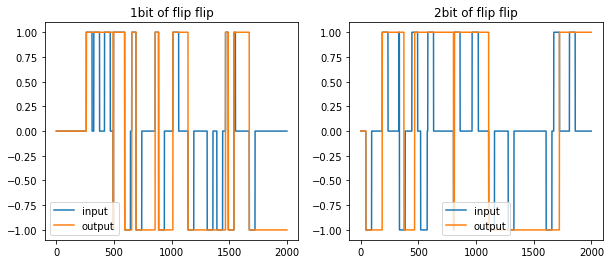

In [8]:
visualize_flip_flop(u_2bit, z_2bit)

##### STEP 3: Instantiate class object

In [9]:
model = esn_model(k=2, n_reservoir=350, spectral_radius=0.95, sparsity=0, leaky_rate=1, epsilon=0.001, lamda=1e-6)

##### STEP 4: Calling Model fit function
> using `model.fit(u, z)`

In [10]:
pred = model.fit(u_2bit, z_2bit)

  8%|▊         | 792/9999 [00:00<00:01, 7911.33it/s]

Training Progress: ....


100%|██████████| 9999/9999 [00:01<00:00, 5867.82it/s]


Performing Redout weight optimization......

Performing predictions....
Done.


##### STEP 5: Calculating Root Mean Squared Error
> using `np.sqrt(np.mean())` by comparing actual and predicted outputs

In [11]:
mse_error = np.sqrt(np.mean((pred - z_2bit)**2))
print("MSE error for {} bit flip flop task is {}".format(u_2bit.shape[1], np.round(mse_error, 5)))

MSE error for 2 bit flip flop task is 0.00319


##### STEP 6: Visualize the actual vs predicted output
> using `visualize_predictions(pred,z)`

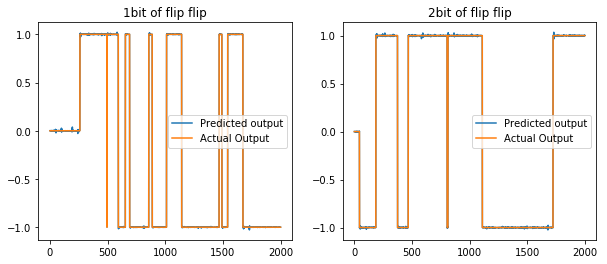

In [12]:
visualize_predictions(pred, z_2bit)

##### STEP 7: Exploring effect of hyperparameters
> **for three hyperparameters: *n_reservoir, spectral_radius, lamda***

In [13]:
#SEARCH SPACE
n_reservoir = [500, 700]
spectral_radius = [0.90, 1]
lamda = [1e-6, 1e-8]

params = [n_reservoir, spectral_radius, lamda]


optim_params = tune_hyperparams(u_2bit, z_2bit, params, model)

  3%|▎         | 260/9999 [00:00<00:03, 2594.84it/s]

Training Progress: ....


100%|██████████| 9999/9999 [00:02<00:00, 3363.85it/s]


Performing Redout weight optimization......

Performing predictions....
Done.
Least MSE error is 0.0007 for model with: number of reservoirs = 700, spectral_radius = 0.9 and lamda=1e-08


  2%|▏         | 194/9999 [00:00<00:05, 1934.26it/s]

Training Progress: ....


100%|██████████| 9999/9999 [00:02<00:00, 3448.63it/s]


Performing Redout weight optimization......

Performing predictions....
Done.
Least MSE error is 0.0007 for model with: number of reservoirs = 700, spectral_radius = 0.9 and lamda=1e-08


  7%|▋         | 721/9999 [00:00<00:02, 3849.51it/s]

Training Progress: ....


100%|██████████| 9999/9999 [00:02<00:00, 3538.42it/s]


Performing Redout weight optimization......

Performing predictions....
Done.
Least MSE error is 0.0007 for model with: number of reservoirs = 700, spectral_radius = 0.9 and lamda=1e-08


  2%|▏         | 158/9999 [00:00<00:06, 1579.24it/s]

Training Progress: ....


100%|██████████| 9999/9999 [00:01<00:00, 5224.33it/s]


Performing Redout weight optimization......

Performing predictions....
Done.


  2%|▏         | 154/9999 [00:00<00:06, 1539.67it/s]

Training Progress: ....


100%|██████████| 9999/9999 [00:03<00:00, 3320.57it/s]


Performing Redout weight optimization......

Performing predictions....
Done.


  2%|▏         | 178/9999 [00:00<00:05, 1707.39it/s]

Training Progress: ....


100%|██████████| 9999/9999 [00:02<00:00, 3731.17it/s]


Performing Redout weight optimization......

Performing predictions....
Done.


  2%|▏         | 155/9999 [00:00<00:06, 1548.30it/s]

Training Progress: ....


100%|██████████| 9999/9999 [00:02<00:00, 3456.49it/s]


Performing Redout weight optimization......

Performing predictions....
Done.


  3%|▎         | 269/9999 [00:00<00:03, 2658.33it/s]

Training Progress: ....


100%|██████████| 9999/9999 [00:02<00:00, 3473.55it/s]


Performing Redout weight optimization......

Performing predictions....
Done.


Optimal Hyperparams are: 
{'reservoir': 700, 'radius': 0.9, 'reg': 1e-08}





  2%|▏         | 221/9999 [00:00<00:04, 2202.28it/s]

Training Progress: ....


100%|██████████| 9999/9999 [00:04<00:00, 2203.32it/s]


Performing Redout weight optimization......

Performing predictions....
Done.
MSE error for 2 bit flip flop task using optimal hyperparameters is 0.0007


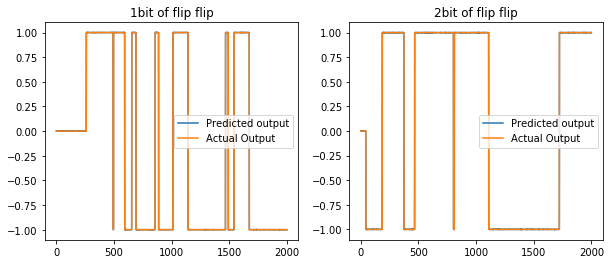

In [14]:
print("Optimal Hyperparams are: ")
print(optim_params)
print("\n\n")

#performing training with these params
model = esn_model(k=2, n_reservoir=optim_params['reservoir'], spectral_radius=optim_params['radius'], lamda=optim_params['reg'])
pred = model.fit(u_2bit, z_2bit)
mse_error = np.sqrt(np.mean((pred - z_2bit)**2))
print("MSE error for {} bit flip flop task using optimal hyperparameters is {}".format(u_2bit.shape[1], np.round(mse_error, 5)))
visualize_predictions(pred, z_2bit)

### 1.5  Three Bit (k=3) flip flop task

##### STEP 1: Generating the dataset of 10, 000 samples.
> `k=3 and n_ts=10000`

In [15]:
u_3bit, z_3bit = flipflop_dataset_generate(k=3, n_ts=10000)

##### STEP 2: Visualize the dataset generated.
> using `visualize_flip_flop(u,z)`

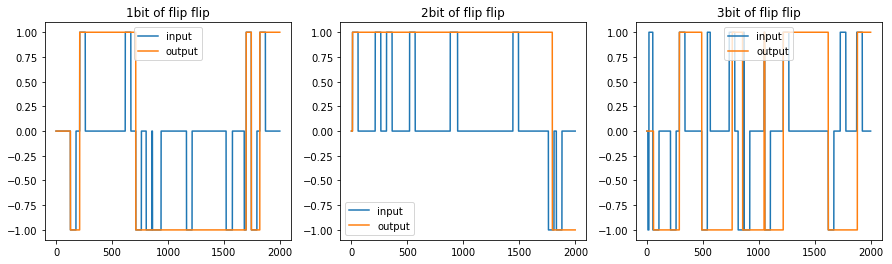

In [16]:
visualize_flip_flop(u_3bit, z_3bit)

##### STEP 3: Instantiate class object

In [17]:
model = esn_model(k=3, n_reservoir=300, spectral_radius=0.95, sparsity=0, leaky_rate=1, epsilon=0.001, lamda=1e-6)

##### STEP 4: Calling Model fit function
> using `model.fit(u, z)`

In [18]:
pred = model.fit(u_3bit, z_3bit)

  5%|▍         | 475/9999 [00:00<00:02, 4744.86it/s]

Training Progress: ....


100%|██████████| 9999/9999 [00:01<00:00, 5240.95it/s]

Performing Redout weight optimization......

Performing predictions....
Done.


##### STEP 5: Calculating Root Mean Squared Error
> using `np.sqrt(np.mean())` by comparing actual and predicted outputs

In [19]:
mse_error = np.sqrt(np.mean((pred - z_3bit)**2))
print("MSE error for {} bit flip flop task is {}".format(u_3bit.shape[1], np.round(mse_error, 5)))

MSE error for 3 bit flip flop task is 0.03592


##### STEP 6: Visualize the actual vs predicted output
> using `visualize_predictions(pred,z)`

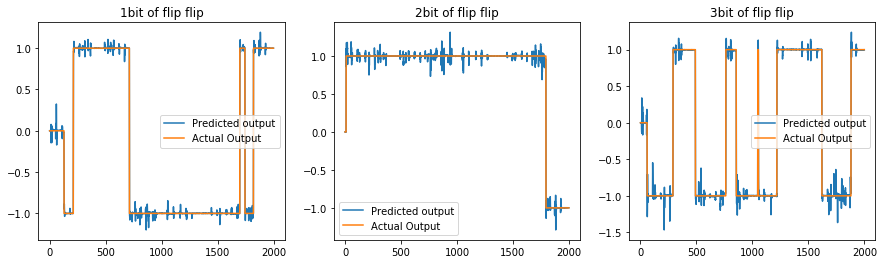

In [20]:
visualize_predictions(pred, z_3bit)

##### STEP 7: Exploring effect of hyperparameters
> **for three hyperparameters: *n_reservoir, spectral_radius, lamda***

In [21]:
#SEARCH SPACE
n_reservoir = [800, 1000]
spectral_radius = [0.90, 1]
lamda = [1e-4, 1e-6, 1e-8]

params = [n_reservoir, spectral_radius, lamda]


optim_params = tune_hyperparams(u_3bit, z_3bit, params, model)

  1%|          | 50/9999 [00:00<00:20, 494.92it/s]

Training Progress: ....


100%|██████████| 9999/9999 [00:11<00:00, 867.00it/s] 


Performing Redout weight optimization......

Performing predictions....
Done.
Least MSE error is 0.00323 for model with: number of reservoirs = 1000, spectral_radius = 1 and lamda=0.0001


  2%|▏         | 154/9999 [00:00<00:06, 1535.48it/s]

Training Progress: ....


100%|██████████| 9999/9999 [00:04<00:00, 2093.21it/s]


Performing Redout weight optimization......

Performing predictions....
Done.


  1%|▏         | 148/9999 [00:00<00:06, 1477.85it/s]

Training Progress: ....


100%|██████████| 9999/9999 [00:04<00:00, 2388.69it/s]


Performing Redout weight optimization......

Performing predictions....
Done.


  2%|▏         | 235/9999 [00:00<00:04, 2348.95it/s]

Training Progress: ....


100%|██████████| 9999/9999 [00:05<00:00, 1835.57it/s]


Performing Redout weight optimization......

Performing predictions....
Done.


  1%|          | 52/9999 [00:00<00:19, 518.05it/s]

Training Progress: ....


100%|██████████| 9999/9999 [00:10<00:00, 999.22it/s] 


Performing Redout weight optimization......

Performing predictions....
Done.
Least MSE error is 0.00323 for model with: number of reservoirs = 1000, spectral_radius = 1 and lamda=1e-08


  1%|          | 83/9999 [00:00<00:11, 828.70it/s]

Training Progress: ....


100%|██████████| 9999/9999 [00:11<00:00, 867.07it/s] 


Performing Redout weight optimization......

Performing predictions....
Done.


  1%|          | 83/9999 [00:00<00:13, 760.32it/s]

Training Progress: ....


100%|██████████| 9999/9999 [00:06<00:00, 1606.53it/s]


Performing Redout weight optimization......

Performing predictions....
Done.


  1%|          | 109/9999 [00:00<00:09, 1078.91it/s]

Training Progress: ....


100%|██████████| 9999/9999 [00:05<00:00, 1904.59it/s]


Performing Redout weight optimization......

Performing predictions....
Done.


  1%|          | 110/9999 [00:00<00:09, 1092.20it/s]

Training Progress: ....


100%|██████████| 9999/9999 [00:09<00:00, 1002.01it/s]


Performing Redout weight optimization......

Performing predictions....
Done.
Least MSE error is 0.00323 for model with: number of reservoirs = 1000, spectral_radius = 1 and lamda=1e-08


  1%|          | 51/9999 [00:00<00:19, 508.36it/s]

Training Progress: ....


100%|██████████| 9999/9999 [00:09<00:00, 1010.13it/s]


Performing Redout weight optimization......

Performing predictions....
Done.
Least MSE error is 0.002 for model with: number of reservoirs = 1000, spectral_radius = 0.9 and lamda=1e-06


  1%|          | 114/9999 [00:00<00:08, 1116.50it/s]

Training Progress: ....


100%|██████████| 9999/9999 [00:05<00:00, 1914.64it/s]


Performing Redout weight optimization......

Performing predictions....
Done.


  2%|▏         | 191/9999 [00:00<00:05, 1906.84it/s]

Training Progress: ....


100%|██████████| 9999/9999 [00:06<00:00, 1631.93it/s]


Performing Redout weight optimization......

Performing predictions....
Done.


Optimal Hyperparams are: 
{'reservoir': 1000, 'radius': 0.9, 'reg': 1e-06}





  0%|          | 44/9999 [00:00<00:23, 424.19it/s]

Training Progress: ....


100%|██████████| 9999/9999 [00:11<00:00, 856.59it/s] 


Performing Redout weight optimization......

Performing predictions....
Done.
MSE error for 3 bit flip flop task using optimal hyperparameters is 0.002


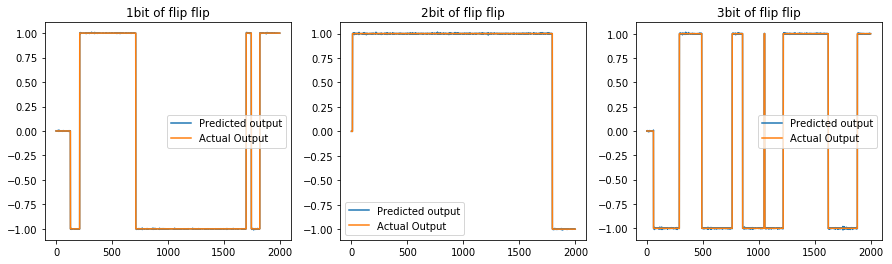

In [22]:
print("Optimal Hyperparams are: ")
print(optim_params)
print("\n\n")

#performing training with these params
model = esn_model(k=3, n_reservoir=optim_params['reservoir'], spectral_radius=optim_params['radius'], lamda=optim_params['reg'])
pred = model.fit(u_3bit, z_3bit)
mse_error = np.sqrt(np.mean((pred - z_3bit)**2))
print("MSE error for {} bit flip flop task using optimal hyperparameters is {}".format(u_3bit.shape[1], np.round(mse_error, 5)))
visualize_predictions(pred, z_3bit)

### 1.6  Four Bit (k=4) flip flop task

##### STEP 1: Generating the dataset of 10, 000 samples.
> `k=4 and n_ts=10000`

In [23]:
u_4bit, z_4bit = flipflop_dataset_generate(k=4, n_ts=10000)

##### STEP 2: Visualize the dataset generated.
> using `visualize_flip_flop(u,z)`

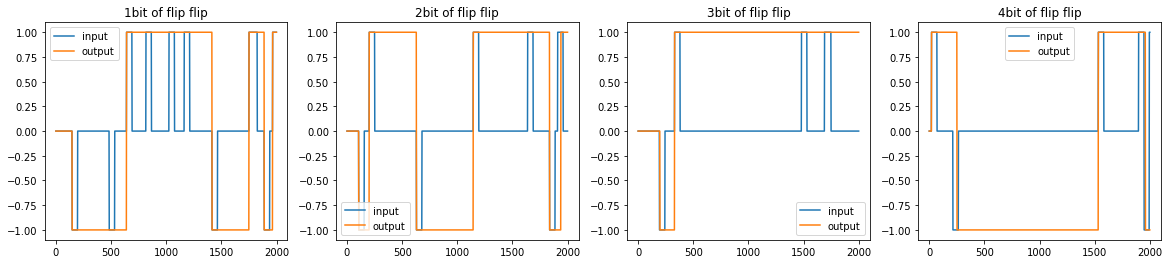

In [24]:
visualize_flip_flop(u_4bit, z_4bit)

##### STEP 3: Instantiate class object

In [25]:
model = esn_model(k=4, n_reservoir=300, spectral_radius=0.95, sparsity=0, leaky_rate=1, epsilon=0.001, lamda=1e-6)

##### STEP 4: Calling Model fit function
> using `model.fit(u, z)`

In [26]:
pred = model.fit(u_4bit, z_4bit)

  6%|▌         | 624/9999 [00:00<00:01, 6235.65it/s]

Training Progress: ....


100%|██████████| 9999/9999 [00:01<00:00, 9624.26it/s] 


Performing Redout weight optimization......

Performing predictions....
Done.


##### STEP 5: Calculating Root Mean Squared Error
> using `np.sqrt(np.mean())` by comparing actual and predicted outputs

In [27]:
mse_error = np.sqrt(np.mean((pred - z_4bit)**2))
print("MSE error for {} bit flip flop task is {}".format(u_4bit.shape[1], np.round(mse_error, 5)))

MSE error for 4 bit flip flop task is 0.05185


##### STEP 6: Visualize the actual vs predicted output
> using `visualize_predictions(pred,z)`

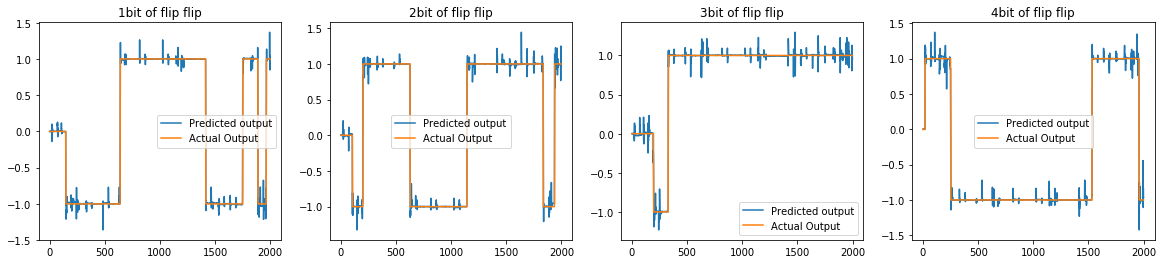

In [28]:
visualize_predictions(pred, z_4bit)

##### STEP 7: Exploring effect of hyperparameters
> **for three hyperparameters: *n_reservoir, spectral_radius, lamda***

In [29]:
#SEARCH SPACE
n_reservoir = [1200, 1500]
spectral_radius = [0.90, 1]
lamda = [1e-10, 1e-6, 1e-8]

params = [n_reservoir, spectral_radius, lamda]


optim_params = tune_hyperparams(u_4bit, z_4bit, params, model)

  0%|          | 44/9999 [00:00<00:22, 433.51it/s]

Training Progress: ....


100%|██████████| 9999/9999 [00:25<00:00, 388.55it/s]


Performing Redout weight optimization......

Performing predictions....
Done.
Least MSE error is 0.00331 for model with: number of reservoirs = 1500, spectral_radius = 1 and lamda=1e-06


  0%|          | 37/9999 [00:00<00:27, 365.54it/s]

Training Progress: ....


100%|██████████| 9999/9999 [00:19<00:00, 509.17it/s]


Performing Redout weight optimization......

Performing predictions....
Done.


  1%|          | 83/9999 [00:00<00:12, 824.51it/s]

Training Progress: ....


100%|██████████| 9999/9999 [00:19<00:00, 518.33it/s]


Performing Redout weight optimization......

Performing predictions....
Done.


  0%|          | 46/9999 [00:00<00:21, 459.49it/s]

Training Progress: ....


100%|██████████| 9999/9999 [00:28<00:00, 346.88it/s]


Performing Redout weight optimization......

Performing predictions....
Done.
Least MSE error is 0.00331 for model with: number of reservoirs = 1500, spectral_radius = 1 and lamda=1e-06


  0%|          | 48/9999 [00:00<00:21, 469.03it/s]

Training Progress: ....


100%|██████████| 9999/9999 [00:16<00:00, 591.07it/s]


Performing Redout weight optimization......

Performing predictions....
Done.


  0%|          | 49/9999 [00:00<00:20, 483.90it/s]

Training Progress: ....


100%|██████████| 9999/9999 [00:22<00:00, 437.55it/s]


Performing Redout weight optimization......

Performing predictions....
Done.
Least MSE error is 0.00331 for model with: number of reservoirs = 1500, spectral_radius = 1 and lamda=1e-10


  1%|          | 66/9999 [00:00<00:15, 658.98it/s]

Training Progress: ....


100%|██████████| 9999/9999 [00:18<00:00, 540.13it/s]


Performing Redout weight optimization......

Performing predictions....
Done.


  1%|          | 70/9999 [00:00<00:14, 694.16it/s]

Training Progress: ....


100%|██████████| 9999/9999 [00:18<00:00, 544.96it/s]


Performing Redout weight optimization......

Performing predictions....
Done.


  1%|          | 52/9999 [00:00<00:19, 517.96it/s]

Training Progress: ....


100%|██████████| 9999/9999 [00:17<00:00, 560.48it/s]


Performing Redout weight optimization......

Performing predictions....
Done.


  0%|          | 48/9999 [00:00<00:20, 479.37it/s]

Training Progress: ....


100%|██████████| 9999/9999 [00:28<00:00, 347.84it/s]


Performing Redout weight optimization......

Performing predictions....
Done.


  1%|          | 50/9999 [00:00<00:20, 495.03it/s]

Training Progress: ....


100%|██████████| 9999/9999 [00:28<00:00, 349.11it/s]


Performing Redout weight optimization......

Performing predictions....
Done.


  1%|          | 55/9999 [00:00<00:19, 499.17it/s]

Training Progress: ....


100%|██████████| 9999/9999 [00:26<00:00, 383.46it/s]


Performing Redout weight optimization......

Performing predictions....
Done.
Least MSE error is 0.00331 for model with: number of reservoirs = 1500, spectral_radius = 1 and lamda=1e-10


Optimal Hyperparams are: 
{'reservoir': 1500, 'radius': 1, 'reg': 1e-10}





  0%|          | 34/9999 [00:00<00:30, 330.15it/s]

Training Progress: ....


100%|██████████| 9999/9999 [00:27<00:00, 368.71it/s]


Performing Redout weight optimization......

Performing predictions....
Done.
MSE error for 4 bit flip flop task using optimal hyperparameters is 0.00331


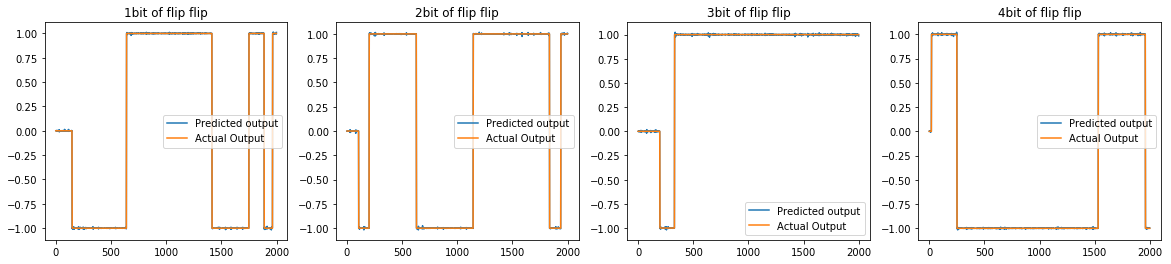

In [30]:
print("Optimal Hyperparams are: ")
print(optim_params)
print("\n\n")

#performing training with these params
model = esn_model(k=4, n_reservoir=optim_params['reservoir'], spectral_radius=optim_params['radius'], lamda=optim_params['reg'])
pred = model.fit(u_4bit, z_4bit)
mse_error = np.sqrt(np.mean((pred - z_4bit)**2))
print("MSE error for {} bit flip flop task using optimal hyperparameters is {}".format(u_4bit.shape[1], np.round(mse_error, 5)))
visualize_predictions(pred, z_4bit)

### Conclusions (Part 1)

> A 2, 3 and 4 bit flip flop dataset of 10,000 samples was generated and about 2K samples were visualized.
> ESN model with default parameters was trained for each dataset after which their respective mean square errors were reported and actual vs predicted output was plotted.
> Later, search space of hyperparameters were defined, from which parameters were randomly choosen and model was trained on those set of paramaters to find out the optimal hyperparameters.

**Results:**
- *For 2 bit flip flip, optimal params: ({'reservoir': 700, 'radius': 0.9, 'reg': 1e-08})*
- *For 3 bit flip flip, optimal params: ({'reservoir': 1000, 'radius': 0.9, 'reg': 1e-06})*
- *For 4 bit flip flip, optimal params: ({'reservoir': 1500, 'radius': 1, 'reg': 1e-10})*

***
### Part 2 of the project...
***

### 2.1 Dataset Generation

- **Instead of regenerating the dataset for part 2 of the project, same 2,3 and 4 bit flip flop dataset, so that later performance using both the algorithms implemented can be measured.**
- `u_kbit` and `z_kbit` for $k=2,3 &4$ has been already generated for part 1 of the project, same will be used for part 2 of the project.


### 2.2  FORCE learning Theoretical Background
#### 1. Introduction
Force leaarning algorithm was proposed to train recurrent neural networks because this way of learning is more biologically plausible. Force learning works by modifying synaptic strengths either external or within the network to convert the spontaneous actvity into desired activity patterns [4][4].

Tasks achieved using Force Learning:
* producing complex output patterns
* input output transformations
* motor patterns etc.

#### 2. Different Architectures in FORCE learning
Three types of architectures are used in FORCE learning which can be seen in the figure below where connections shown in red gets modified during training. ![](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2756108/bin/nihms-137176-f0001.jpg)
* **CASE 1:** Feedback is provided to network using readout unit.
* **CASE 2:** Feedback is provided to network using a separate feedback network. Separate feedback network also has neurons connected and recieve input from the network through synapse of strength $g$.
* **CASE 3:** Feedback is generated within the network and modified using FORCE learing.

#### 3. Limitations of RNN
Since chaotic activity is irregular and sensitive to initial conditions, RNN will not converge if they are applied to a chaotic activity. There are mainly three problems associated with them as described below and we try to solve those three problems.
- **Feeding errorneous output** back into the network can cause the network training to diverge from what is required and hence failing the network to converge.
     - This problem was solved by removing all the errors from the output before feeding back into the network. But this solution poses another challenge, feedback back the output similar to actual output will cause the network instabilizations by avoiding the network from sampling fluctuations.
     - Synaptic modifiation procedure can be used to modify the outpur fed back into the network, allowing the fluctuations to be sampled and stabilized at the same time.
- **Credit Asssignment for errors**. Here, neurons which directly lead to output errors are figured and are modified.
- Training in the face of chaotic activity.
    - This problem is solved by starting the networks that were inactive in the absence of input.


#### 4. Algorithm and training steps
FORCE learning is different from traditional learning procedures. In traditional learning, sequence of modifcations are done and the main aim is to reduce errors in the network output.On the other hand, in FORCE learning, errors are already small, even from the starting of the training. So the main goal, is not error reduction but the to reduce the number of modifications required to keep the error small. At the end of training, no modifications will be required and network can generate the desired output.


> Network output is calculated using $z(t) = w^{T}r(t)$ where w is the weights vector and r(t) is the activity of the network neurons at time t.

> **WHAT THE NETWORK DOES:** Network is asked to perform $z(t) = f(t)$ where, f(t) is target function. The goal of the network is to produce the target function in the absence of any input.

> All the network architectures described above, gives a delayed effect, when resulting change in the output caused by modifying w propagates repeatedly along the feedback pathway and through the network, changing network activities [4][4]. To solve this, we perform the error-based modification of the readout weights. We allow errors to be fed back into the network, but at the same time, keeping them small enough to make rapid weight modifications. As long as the errors are small, learning can be continued without any disruption, without any delay. This type of training is known as **First-Order, Reduced and Controlled Error or FORCE learning**

> **WEIGHT UPDATE:** All the weight updates happen in interval $\Delta$t. In each update, output of the network is calculated, how far this output deviates from the target function is determined and readout weights are modified accordingly. At time t, network output is calculated as $w^{T}(t-\Delta $t$)r(t)$.

> **ERROR CALCULATION:** Comapring with $f(t)$, error is computer before weight updation as $e(t) = w^{T}(t-\Delta $t$)r(t) - f(t)$.

#### 5. RLS Learning
Several modifications can be used, but **recursive least squares (RLS) algorithm** is particularly powerful and used here [5][5]. In RLS modification, weight update happens as:

$w(t) = w(t-\Delta$t$- e(t)P(t)r(t)$ where, 

P(t) is an N × N matrix that is updated at the same time as the weights, and algorithm requires its initial value as $P(0) = I/\alpha$, alpha here is learning rate.

[4]: <https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2756108/>
[5]: <https://www.worldcat.org/title/adaptive-filter-theory/oclc/46538540>

### 2.3 FORCE learning using RLS Model

In [31]:
class force_with_rls:
    def __init__(self, k, num_neurons=1000, g=1.5, alpha=1, tau=20, train_delta=2):
        """
        Args:
            k: number of bits for flip flop task
            g: 
            alpha: leaky rate
            tau: 
            train_delta: 
            num_neurons: number of neuron units present in the reservoir layer
        """
        self.k = k
        self.num_neurons = num_neurons
        self.g = g
        self.alpha = alpha
        self.tau = tau
        self.train_delta = train_delta
        
        #initialize network
        self.initialize_network()
        
    def initialize_network(self):
        
        #initialize feedback weights
        self.w_fb = 2.0 * (np.random.rand(self.num_neurons, self.k) - 0.5)
            
        #initialize recurrent weights
        self.w_r = np.random.normal(0, math.sqrt(math.pow(self.g,2)/self.num_neurons), size=(self.num_neurons, self.num_neurons))
        
        #initialize readout weights
        self.w_o = np.zeros([self.k, self.num_neurons])
        
        #initialize bias of network
        self.b = 2.0 * (np.random.rand(self.num_neurons, self.k) - 0.5)
        
    def fit(self, inp, out):
        
        #initial state
        x = 0.5*np.random.randn(self.num_neurons,1)
        
        #P matrix of shape (N X N)
        P = (1.0/self.alpha)*np.eye(self.num_neurons)
        
        #initialize predicted target matrix
        pred = np.zeros([self.k,inp.shape[0]])
        
        #initialize matrix to store mean squared errors
        mean_sqaure_error = np.zeros([1,int(inp.shape[0]/self.train_delta)])
        
        #starting training by looping over samples
        print("Training Progress......")
        for ts in tqdm(range(1, inp.shape[0])):
            
            #update x,r,z
            r = np.tanh(x)
            z = self.w_o.dot(r)
            u = np.expand_dims(inp.T[:,ts], axis=1)
            
            #calculate xdot
            xdot = -x + self.w_r.dot(r) + self.w_fb.dot(z) + self.b.dot(u)
            
            #update state
            x = x + xdot/self.tau
            
            #we do weight updation if
            if ts% self.train_delta ==0: 
                
                #compute P(t) from P(t-deltaT) 
                k = P.dot(r)
                rPr = r.T.dot(k)
                
                c = 1.0/(1.0 + rPr)
                
                P = P - k*(k.T*c)
                
                #calculate error
                e = z-np.expand_dims(out.T[:,ts], axis=1)
                
                #weight updation
                dW = -e*k.T*c
                self.w_o = self.w_o + dW
                
                #store error in mean_sqaure_error matrix
                mean_sqaure_error[0,int(ts/self.train_delta)] = np.mean(np.power(e,2))
                
            
            #recording model output
            pred[:,ts]=np.squeeze(z)
            
        return pred, mean_sqaure_error

### 2.4 Two bit (k=2) flip flop task
##### STEP 1: Instantiate class object

In [32]:
model = force_with_rls(2)

##### STEP 2: Calling Model fit function
> using `model.fit(u, z)`

In [33]:
pred, mean_square_error  = model.fit(u_2bit, z_2bit)

  0%|          | 18/9999 [00:00<00:56, 176.06it/s]

Training Progress......


100%|██████████| 9999/9999 [01:00<00:00, 164.58it/s]


##### STEP 3: Calculating Root Mean Squared Error
> using `np.mean()` of mean square error returned by model above.

In [34]:
print("MSE error for {} bit flip flop task is {}".format(u_2bit.shape[1], np.round(np.mean(mean_square_error), 5)))

MSE error for 2 bit flip flop task is 0.04966


##### STEP 4: Visualize the actual vs predicted output
> using `visualize_predictions(pred,z)`

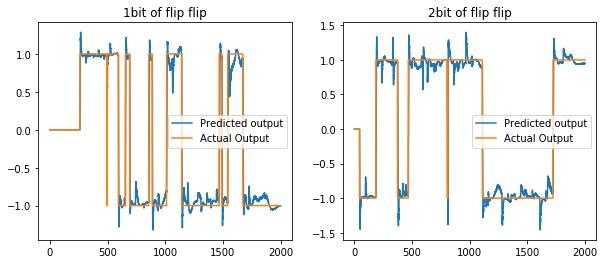

In [35]:
visualize_predictions(pred.T, z_2bit)

##### STEP 5: Hyperparameter Tuning
> `num_neurons` and `alpha`

In [36]:
#SEARCH SPACE
num_neurons = [2500, 3000]
alpha = [0.90, 1]

params = [num_neurons, alpha]
optim_params = tune_hyperparams(u_2bit, z_2bit, params, model)

  0%|          | 0/9999 [00:00<?, ?it/s]

Training Progress......


100%|██████████| 9999/9999 [08:22<00:00, 19.91it/s]


Least MSE error is 0.04053 for model with: number of neurons = 3000, alpha = 1


  0%|          | 4/9999 [00:00<06:32, 25.48it/s]

Training Progress......


100%|██████████| 9999/9999 [06:49<00:00, 24.42it/s]


Least MSE error is 0.03952 for model with: number of neurons = 3000, alpha = 0.9


  0%|          | 4/9999 [00:00<04:26, 37.45it/s]

Training Progress......


  0%|          | 4/9999 [00:00<05:01, 33.13it/s]

Training Progress......


100%|██████████| 9999/9999 [04:38<00:00, 35.89it/s]


Optimal Hyperparams are: 
{'neurons': 3000, 'lr': 0.9}





  0%|          | 4/9999 [00:00<06:07, 27.20it/s]

Training Progress......


100%|██████████| 9999/9999 [06:29<00:00, 25.70it/s]


MSE error for 2 bit flip flop task using optimal hyperparameters is 0.04005


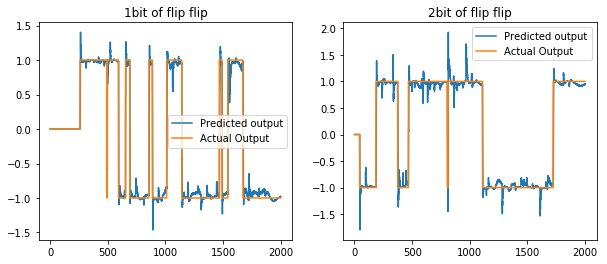

In [37]:
print("Optimal Hyperparams are: ")
print(optim_params)
print("\n\n")

#performing training with these params
model = force_with_rls(k=2, num_neurons=optim_params['neurons'], alpha=optim_params['lr'])
pred, mean_square_error = model.fit(u_2bit, z_2bit)
mse_error = np.mean(mean_square_error)
print("MSE error for {} bit flip flop task using optimal hyperparameters is {}".format(u_2bit.shape[1], np.round(mse_error, 5)))
visualize_predictions(pred.T, z_2bit)

### 2.5 Three bit (k=3) flip flop task
##### STEP 1: Instantiate class object

In [38]:
model = force_with_rls(3)

##### STEP 2: Calling Model fit function
> using `model.fit(u, z)`

In [39]:
pred, mean_square_error  = model.fit(u_3bit, z_3bit)

  0%|          | 32/9999 [00:00<00:32, 310.38it/s]

Training Progress......


100%|██████████| 9999/9999 [00:37<00:00, 266.03it/s]


##### STEP 3: Calculating Root Mean Squared Error
> using `np.mean()` of mean square error returned by model above.

In [40]:
print("MSE error for {} bit flip flop task is {}".format(u_3bit.shape[1], np.round(np.mean(mean_square_error), 5)))

MSE error for 3 bit flip flop task is 0.0339


##### STEP 4: Visualize the actual vs predicted output
> using `visualize_predictions(pred,z)`

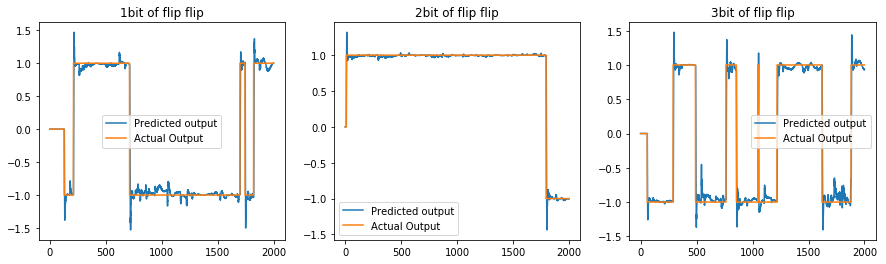

In [41]:
visualize_predictions(pred.T, z_3bit)

##### STEP 5: Hyperparameter Tuning
> `num_neurons` and `alpha`

In [42]:
#SEARCH SPACE
num_neurons = [3000, 2500]
alpha = [1.2, 1]

params = [num_neurons, alpha]
optim_params = tune_hyperparams(u_3bit, z_3bit, params, model)

  0%|          | 4/9999 [00:00<04:28, 37.18it/s]

Training Progress......


100%|██████████| 9999/9999 [04:40<00:00, 35.71it/s]


Least MSE error is 0.02803 for model with: number of neurons = 2500, alpha = 1.2


  0%|          | 4/9999 [00:00<06:30, 25.59it/s]

Training Progress......


100%|██████████| 9999/9999 [06:24<00:00, 25.98it/s]


Least MSE error is 0.02712 for model with: number of neurons = 3000, alpha = 1.2


  0%|          | 4/9999 [00:00<04:24, 37.83it/s]

Training Progress......


  0%|          | 4/9999 [00:00<05:01, 33.16it/s]

Training Progress......


100%|██████████| 9999/9999 [04:40<00:00, 35.60it/s]


Optimal Hyperparams are: 
{'neurons': 3000, 'lr': 1.2}





  0%|          | 4/9999 [00:00<06:28, 25.75it/s]

Training Progress......


100%|██████████| 9999/9999 [06:34<00:00, 25.35it/s]


MSE error for 3 bit flip flop task using optimal hyperparameters is 0.02715


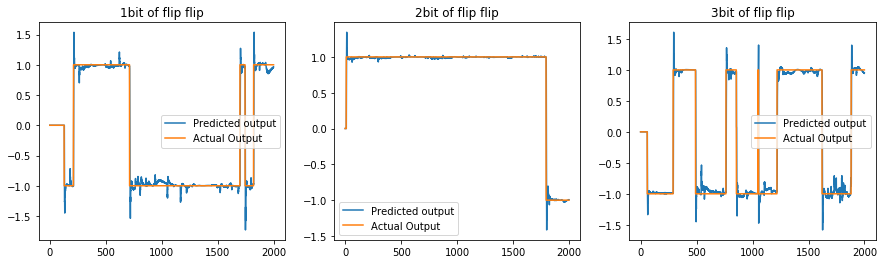

In [43]:
print("Optimal Hyperparams are: ")
print(optim_params)
print("\n\n")

#performing training with these params
model = force_with_rls(k=3, num_neurons=optim_params['neurons'], alpha=optim_params['lr'])
pred, mean_square_error = model.fit(u_3bit, z_3bit)
mse_error = np.mean(mean_square_error)
print("MSE error for {} bit flip flop task using optimal hyperparameters is {}".format(u_3bit.shape[1], np.round(mse_error, 5)))
visualize_predictions(pred.T, z_3bit)

### 2.6 Four bit (k=4) flip flop task
##### STEP 1: Instantiate class object

In [44]:
model = force_with_rls(4)

##### STEP 2: Calling Model fit function
> using `model.fit(u, z)`

In [45]:
pred, mean_square_error  = model.fit(u_4bit, z_4bit)

  0%|          | 25/9999 [00:00<00:40, 248.87it/s]

Training Progress......


100%|██████████| 9999/9999 [00:37<00:00, 266.43it/s]


##### STEP 3: Calculating Root Mean Squared Error
> using `np.mean()` of mean square error returned by model above.

In [46]:
print("MSE error for {} bit flip flop task is {}".format(u_4bit.shape[1], np.round(np.mean(mean_square_error), 5)))

MSE error for 4 bit flip flop task is 0.02885


##### STEP 4: Visualize the actual vs predicted output
> using `visualize_predictions(pred,z)`

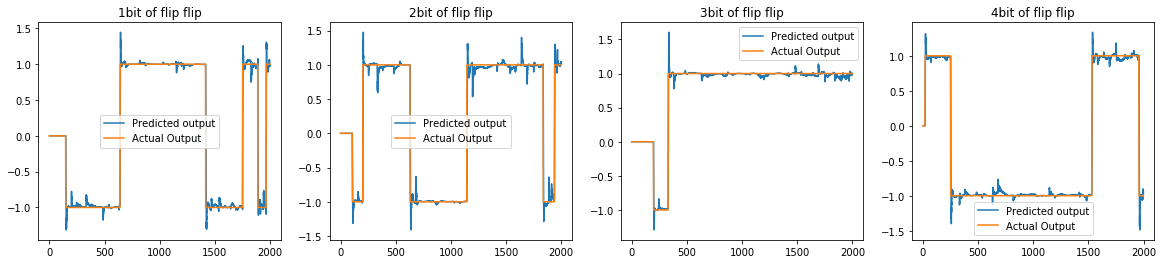

In [47]:
visualize_predictions(pred.T, z_4bit)

##### STEP 5: Hyperparameter Tuning
> `num_neurons` and `alpha`

In [48]:
#SEARCH SPACE
num_neurons = [1000, 1500, 500]
alpha = [0.90, 0.85, 1]

params = [num_neurons, alpha]
optim_params = tune_hyperparams(u_4bit, z_4bit, params, model)

  1%|          | 96/9999 [00:00<00:10, 957.90it/s]

Training Progress......


  0%|          | 20/9999 [00:00<00:52, 190.98it/s]

Least MSE error is 0.03839 for model with: number of neurons = 500, alpha = 0.9
Training Progress......


  1%|          | 87/9999 [00:00<00:11, 868.94it/s]

Least MSE error is 0.02842 for model with: number of neurons = 1000, alpha = 1
Training Progress......


  0%|          | 22/9999 [00:00<00:47, 209.04it/s]

Training Progress......


  0%|          | 0/9999 [00:00<?, ?it/s]

Least MSE error is 0.02816 for model with: number of neurons = 1000, alpha = 0.9
Training Progress......


  1%|          | 110/9999 [00:00<00:09, 1093.56it/s]

Least MSE error is 0.02537 for model with: number of neurons = 1500, alpha = 0.85
Training Progress......


  0%|          | 18/9999 [00:00<00:57, 173.54it/s]

Training Progress......


  0%|          | 10/9999 [00:00<01:48, 91.79it/s]

Training Progress......


  1%|          | 88/9999 [00:00<00:11, 873.58it/s]

Training Progress......


100%|██████████| 9999/9999 [00:10<00:00, 972.54it/s] 


  0%|          | 0/9999 [00:00<?, ?it/s]

Optimal Hyperparams are: 
{'neurons': 1500, 'lr': 0.85}



Training Progress......


100%|██████████| 9999/9999 [01:17<00:00, 129.08it/s]


MSE error for 4 bit flip flop task using optimal hyperparameters is 0.02515


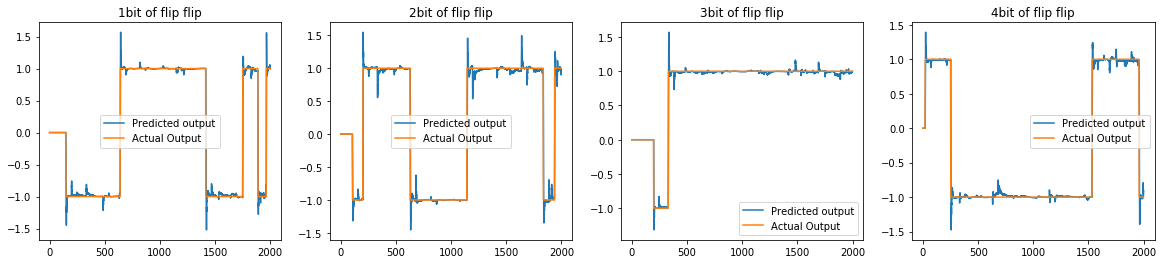

In [50]:
print("Optimal Hyperparams are: ")
print(optim_params)
print("\n\n")


#performing training with these params
model = force_with_rls(k=4, num_neurons=optim_params['neurons'], alpha=optim_params['lr'])
pred, mean_square_error = model.fit(u_4bit, z_4bit)
mse_error = np.mean(mean_square_error)
print("MSE error for {} bit flip flop task using optimal hyperparameters is {}".format(u_4bit.shape[1], np.round(mse_error, 5)))
visualize_predictions(pred.T, z_4bit)

### Conclusions (Part 1)

> A 2, 3 and 4 bit flip flop dataset of 10,000 samples was generated and about 2K samples were visualized.
> Force learning with RLS algorithm using default parameters was trained for each dataset after which their respective mean square errors were reported and actual vs predicted output was plotted.
> Later, search space of hyperparameters were defined, from which parameters were randomly choosen and model was trained on those set of paramaters to find out the optimal hyperparameters.

**Results:**
- *For 2 bit flip flip, optimal params: ({'neurons': 3000, 'lr': 0.9})*
- *For 3 bit flip flip, optimal params: ({'neurons': 3000, 'lr': 1.2})*
- *For 4 bit flip flip, optimal params: ({'neurons': 1500, 'lr': 0.85})*

### Comparison of two approaches
> Both the algorithms have good generalization capability but since here, small dataset of only 10K samples have been used, Echo state networks works well. ESN is more robust and shows good  performance for small training samples.On the other hand, Force Learning algorithms performs better on dataset with larger number of training samples.

#### Thank you